In [1]:
# # generating random spectrograms and saving them as .png files
import numpy as np
import matplotlib.pyplot as plt
import os

# Directory to save generated spectrograms
output_dir = "C:\\Users\\PC\\Desktop\\lisnen_data\\noise\\noise_spectrograms"
os.makedirs(output_dir, exist_ok=True)

# Function to generate random spectrograms
def generate_random_spectrogram(width=227, height=227, channels=3, num_spectrograms=100):
    for i in range(num_spectrograms):
        # Generate random pixel values
        random_spectrogram = np.random.rand(height, width, channels)
        
        # Save the spectrogram as an image
        plt.imsave(os.path.join(output_dir, f"spectrogram_{i}.png"), random_spectrogram)

# Generate 100 random spectrograms
generate_random_spectrogram(num_spectrograms=100)

print(f"Generated 10 random spectrograms of size 227x227 with 3 channels in the directory: {output_dir}")


In [2]:
# import numpy as np
# import matplotlib.pyplot as plt
# import os

# def generate_gaussian_noise_spectrogram(width=227, height=227, channels=3, mean=0, std=0.1, num_spectrograms=100):

#     for i in range(num_spectrograms):
#         # Generate Gaussian noise
#         noise = np.random.normal(mean, std, (height, width, channels))
        
#         # Normalize the noise to the range [0, 1]
#         noise_min = np.min(noise)
#         noise_max = np.max(noise)
#         noise_normalized = (noise - noise_min) / (noise_max - noise_min)

#         # Save the normalized noise spectrogram
#         plt.imsave(os.path.join(output_dir, f"gauss_noise_{i}.png"), noise_normalized)

# # Generate 10 Gaussian noise spectrograms as an example
# generate_gaussian_noise_spectrogram(num_spectrograms=100)


In [3]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.signal import welch

# def generate_pink_noise_spectrogram(width=227, height=227, channels=3, num_spectrograms=100):
#     for i in range(num_spectrograms):
#         # Generate pink noise
#         noise = np.random.randn(height, width, channels)
        
#         # Apply Fourier transform to get the frequency domain representation
#         f_transform = np.fft.fftn(noise)
        
#         # Create a pink noise filter in the frequency domain
#         freqs = np.fft.fftfreq(height, d=1.0/height)
#         freqs = np.fft.fftshift(freqs)
#         pink_filter = np.sqrt(1.0 / (freqs**2 + 1e-6))  # 1e-6 to avoid division by zero
        
#         # Apply the pink noise filter
#         pink_transform = f_transform * pink_filter[:, None, None]
        
#         # Convert back to time domain
#         pink_noise = np.fft.ifftn(pink_transform).real
        
#         # Normalize the noise to be in the range [0, 1]
#         pink_noise = (pink_noise - np.min(pink_noise)) / (np.max(pink_noise) - np.min(pink_noise))

#         # Save the normalized pink noise spectrogram
#         plt.imsave(os.path.join(output_dir, f"pink_noise_spectrogram_{i}.png"), pink_noise)

# # Generate 10 pink noise spectrograms as an example
# generate_pink_noise_spectrogram(num_spectrograms=100)



In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from tqdm import tqdm

In [5]:
import os
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset

# Define paths
base_dir = 'C:\\Users\\PC\\Desktop\\lisnen_data\\noise'
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
}

# Load dataset
full_dataset = ImageFolder(root=base_dir, transform=data_transforms['train'])

# Split dataset
indices = list(range(len(full_dataset)))
train_indices, temp_indices = train_test_split(indices, test_size=0.2, stratify=full_dataset.targets)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, stratify=[full_dataset.targets[i] for i in temp_indices])

# Create subsets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [6]:
# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer to output 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

c:\Users\PC\anaconda3\envs\kd\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC\anaconda3\envs\kd\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

# Training function with progress bar and metric tracking
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=1):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    
    train_precision_history = []
    val_precision_history = []
    train_recall_history = []
    val_recall_history = []
    train_f1_history = []
    val_f1_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()  # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []

            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=f'{phase} {epoch}/{num_epochs - 1}'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            epoch_precision = precision_score(all_labels, all_preds, average='weighted')
            epoch_recall = recall_score(all_labels, all_preds, average='weighted')
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f} F1 Score: {epoch_f1:.4f}')

            # Save the metrics
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
                train_precision_history.append(epoch_precision)
                train_recall_history.append(epoch_recall)
                train_f1_history.append(epoch_f1)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                val_precision_history.append(epoch_precision)
                val_recall_history.append(epoch_recall)
                val_f1_history.append(epoch_f1)

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_precision_history, val_precision_history, train_recall_history, val_recall_history, train_f1_history, val_f1_history

# Train the model
model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_precision_history, val_precision_history, train_recall_history, val_recall_history, train_f1_history, val_f1_history = train_model(
    model, criterion, optimizer, train_loader, val_loader, num_epochs=1)


Epoch 0/0
----------


train 0/0: 100%|██████████| 16/16 [00:04<00:00,  3.89it/s]


train Loss: 0.0525 Acc: 0.9652 Precision: 0.9670 Recall: 0.9652 F1 Score: 0.9651


val 0/0: 100%|██████████| 2/2 [00:00<00:00,  8.24it/s]

val Loss: 0.0000 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1 Score: 1.0000


In [8]:
save_path = 'C:\\Users\\PC\\Desktop\\sample_projects\\transfer_knowledge\\models\\resnet_50_noise.pth'
torch.save(model.state_dict(), save_path)

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataloader, class_names):
    model.eval()  # Set model to evaluation mode
    running_corrects = 0
    all_preds = []
    all_labels = []
    wrong_predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Collect wrong predictions
            wrong_indices = np.where(preds.cpu().numpy() != labels.cpu().numpy())[0]
            for idx in wrong_indices:
                wrong_predictions.append((inputs.cpu()[idx], preds.cpu().numpy()[idx], labels.cpu().numpy()[idx]))

    accuracy = running_corrects.double() / len(dataloader.dataset)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1 Score: {f1:.4f}')
    
    return wrong_predictions,all_labels,all_preds

# Evaluate the model on the test data
class_names = ['noise','not noise']
wrong_predictions = evaluate_model(model, test_loader, class_names)




Test Accuracy: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1 Score: 1.0000


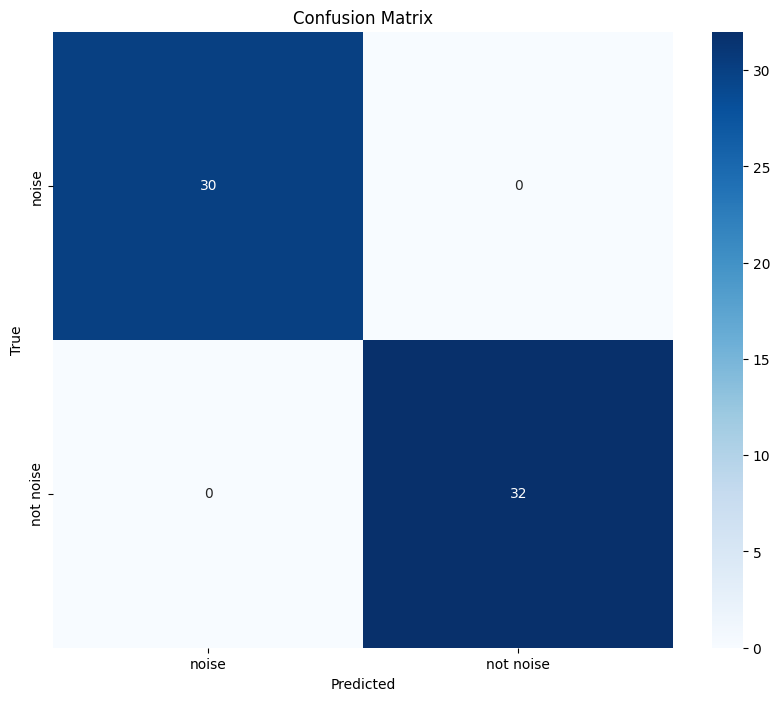

              precision    recall  f1-score   support

       noise       1.00      1.00      1.00        30
   not noise       1.00      1.00      1.00        32

    accuracy                           1.00        62
   macro avg       1.00      1.00      1.00        62
weighted avg       1.00      1.00      1.00        62

Class: noise
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Support: 30.0
--------------------
Class: not noise
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Support: 32.0
--------------------


In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model_with_confusion_matrix(model, dataloader, class_names):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Print individual metrics for each class
    for class_name, metrics in cr.items():
        if class_name in class_names:
            print(f"Class: {class_name}")
            print(f"Precision: {metrics['precision']:.4f}")
            print(f"Recall: {metrics['recall']:.4f}")
            print(f"F1 Score: {metrics['f1-score']:.4f}")
            print(f"Support: {metrics['support']}")
            print("-" * 20)

# Evaluate the model on the test data with confusion matrix and detailed metrics
evaluate_model_with_confusion_matrix(model, test_loader, class_names)
